In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# **1.Representation**

In [ ]:
# Standardize the data， every pixel is [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Download the CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:01<00:00, 99.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Create the Dataloader
trainloader = DataLoader(trainset, batch_size=128, shuffle=True) # trainloader[i] is a tuple, [0] contains [64, 3, 32, 32], [1] contains label.
testloader = DataLoader(testset, batch_size=128, shuffle=False)

print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")

Training set size: 50000
Test set size: 10000


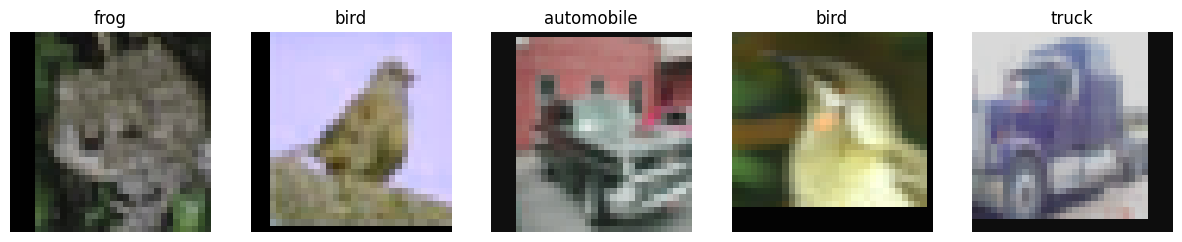

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize some data
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

data_iter = iter(trainloader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axes[i]
    img = images[i] / 2 + 0.5
    ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    ax.set_title(classes[labels[i]])
    ax.axis('off')

plt.show()

# **2. Loss and Net Architecture**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
from torch.optim.lr_scheduler import StepLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        # self.in_planes = 64

        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
        #                        stride=1, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(64)
        # self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        # self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        # self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # self.linear = nn.Linear(512*block.expansion, num_classes)

        self.in_planes = 32


        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet50():
    return ResNet(Bottleneck, [2, 2, 2, 2])

model = ResNet50().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


Using device: cuda


In [ ]:
# find the parameters
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           1,024
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7          [-1, 128, 32, 32]           4,096
       BatchNorm2d-8          [-1, 128, 32, 32]             256
            Conv2d-9          [-1, 128, 32, 32]           4,096
      BatchNorm2d-10          [-1, 128, 32, 32]             256
       Bottleneck-11          [-1, 128, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           4,096
      BatchNorm2d-13           [-1, 32, 32, 32]              64
           Conv2d-14           [-1, 32,

# **3.Optimize**

In [ ]:
num_epochs = 80
starting_epoch = 80
# model.train()
losses = []
accuracies = []
best_loss = float('inf')
best_model_path = 'best_model.pth'
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=20, gamma=0.15)
print("using sgd")
checkpoint = torch.load('model_epoch_130.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
starting_epoch = checkpoint['epoch'] + 1 + 1
# print(starting_epoch)
print("Choose the Model Information:")
print(f"Epoch: {checkpoint['epoch'] + 1}")  #
print(f"Loss: {checkpoint['loss']:.4f}")

using sgd
Choose the Model Information:
Epoch: 130
Loss: 0.0217


<ipython-input-14-f075e73c16ac>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_epoch_130.pth')


In [ ]:
# Training the model
# num_epochs = 80
num_epochs = 80
starting_epoch = 80
# model.train()
losses = []
accuracies = []
best_loss = float('inf')
best_model_path = 'best_model.pth'
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
print("using sgd")
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(trainloader):
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if i % 100 == 0:
#           print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(trainloader)}], Loss: {loss.item():.4f}")

#     epoch_loss = running_loss / len(trainloader)
#     losses.append(epoch_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")

#     scheduler.step()
for epoch in range(starting_epoch, starting_epoch + num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
          print(f"Epoch [{epoch+1}/{starting_epoch + num_epochs }], Step [{i}/{len(trainloader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{starting_epoch + num_epochs}], Average Loss: {epoch_loss:.4f}")


    scheduler.step()

    print(f"Learning rate adjusted to {scheduler.get_last_lr()[0]}")

    # store the model per 5 epochs
    if (epoch + 1) % 5 == 0:

        checkpoint_path = f'model_epoch_{epoch+1}.pth'
        # checkpoint_path = f'model_epoch_{epoch+0}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1} with loss: {epoch_loss:.4f}")

    # store the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, best_model_path)
        print(f"Model saved with loss: {best_loss:.4f}")


    # Computing accuracy of every epoch
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
      for inputs, labels in testloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    accuracies.append(accuracy)

    print(f"Test Accuracy: {accuracy:.4f}")
        # losses.append(loss)
print("Training complete!")

using sgd
Epoch [81/160], Step [0/391], Loss: 0.0120
Epoch [81/160], Step [100/391], Loss: 0.0483
Epoch [81/160], Step [200/391], Loss: 0.0318
Epoch [81/160], Step [300/391], Loss: 0.0631
Epoch [81/160], Average Loss: 0.0400
Learning rate adjusted to 0.001
Model saved with loss: 0.0400
Test Accuracy: 0.9279
Epoch [82/160], Step [0/391], Loss: 0.0383
Epoch [82/160], Step [100/391], Loss: 0.0284
Epoch [82/160], Step [200/391], Loss: 0.0734
Epoch [82/160], Step [300/391], Loss: 0.0477
Epoch [82/160], Average Loss: 0.0367
Learning rate adjusted to 0.001
Model saved with loss: 0.0367
Test Accuracy: 0.9283
Epoch [83/160], Step [0/391], Loss: 0.0283
Epoch [83/160], Step [100/391], Loss: 0.0234
Epoch [83/160], Step [200/391], Loss: 0.0443
Epoch [83/160], Step [300/391], Loss: 0.0765
Epoch [83/160], Average Loss: 0.0357
Learning rate adjusted to 0.001
Model saved with loss: 0.0357
Test Accuracy: 0.9275
Epoch [84/160], Step [0/391], Loss: 0.0327
Epoch [84/160], Step [100/391], Loss: 0.0135
Epoch

In [ ]:
# print best model information
checkpoint = torch.load(best_model_path)

print("Best Model Information:")
print(f"Epoch: {checkpoint['epoch'] + 1}")  #
print(f"Loss: {checkpoint['loss']:.4f}")

Best Model Information:
Epoch: 155
Loss: 0.0201


<ipython-input-18-d04168d29633>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


In [ ]:
model_path = "model_epoch_130.pth"
checkpoint = torch.load(model_path)

print("Choose the Model Information:")
print(f"Epoch: {checkpoint['epoch'] + 1}")  #
print(f"Loss: {checkpoint['loss']:.4f}")
# acc = accuracies[checkpoint['epoch']]
# print(f"Accuracy: {acc:.4f}")

Choose the Model Information:
Epoch: 130
Loss: 0.0217


<ipython-input-16-ee0ba334afe5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [ ]:
# Evaluating the model
import torch
from sklearn.metrics import accuracy_score

model = ResNet50().to(device)
# checkpoint = torch.load('best_model.pth')

# choose the model you like
checkpoint = torch.load(model_path)

# related information
print(f"Epoch: {checkpoint['epoch'] + 1}")  #
model.load_state_dict(checkpoint['model_state_dict'])

best_epoch = checkpoint['epoch']
best_loss = checkpoint['loss']
print(f"Loaded model from epoch {best_epoch+1} with loss {best_loss:.4f}")

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

<ipython-input-17-c9453f5cb2bb>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Epoch: 130
Loaded model from epoch 130 with loss 0.0217
Test Accuracy: 0.9316


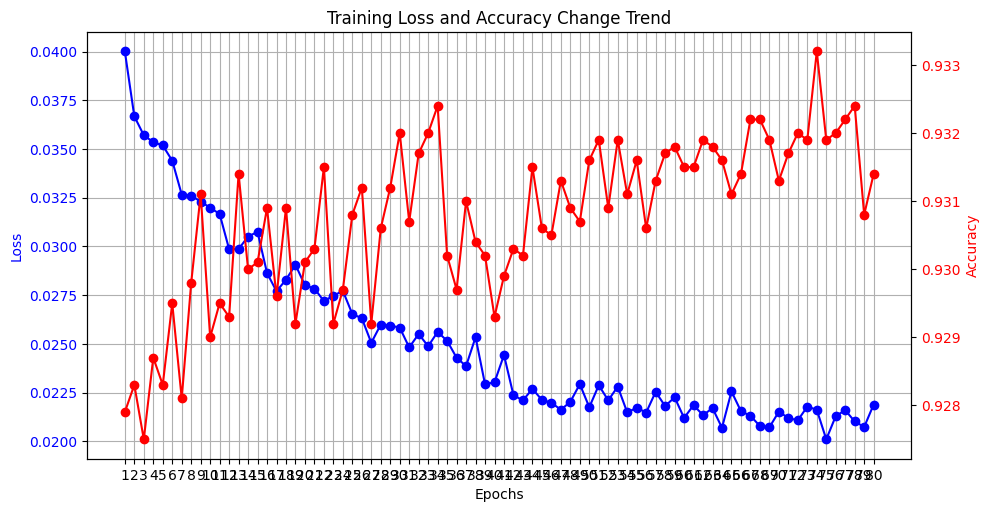

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))

# plt.plot(range(1, len(losses) + 1), losses, label="Training Loss", color='b', marker='o')

# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training Loss Change Trend")

# # plt.xticks(range(1, len(losses) + 1, max(1, len(losses) // 10)))
# plt.xticks(range(1, len(losses) + 1))

# plt.grid(True)
# plt.legend()

# plt.show()

# loss
fig, ax1 = plt.subplots(figsize=(10, 5))

color_loss = 'b'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color_loss)
ax1.plot(range(1, len(losses) + 1), losses, label="Training Loss", color=color_loss, marker='o')
ax1.tick_params(axis='y', labelcolor=color_loss)
ax1.set_xticks(range(1, len(losses) + 1))
ax1.grid(True)

# accuracy
ax2 = ax1.twinx()
color_acc = 'r'
ax2.set_ylabel('Accuracy', color=color_acc)
ax2.plot(range(1, len(accuracies) + 1), accuracies, label="Accuracy", color=color_acc, marker='o')
ax2.tick_params(axis='y', labelcolor=color_acc)

fig.tight_layout()
plt.title("Training Loss and Accuracy Change Trend")
plt.show()

# **4. Test**

First we need to download the test dataset in https://www.kaggle.com/competitions/deep-learning-spring-2025-project-1/data and then upload to google colab

In [ ]:
# Get Test Dataset
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict


<class 'dict'>
dict_keys([b'data', b'ids'])
[   0    1    2 ... 9997 9998 9999]
(10000, 32, 32, 3)


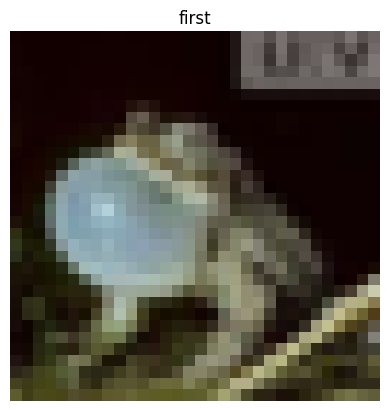

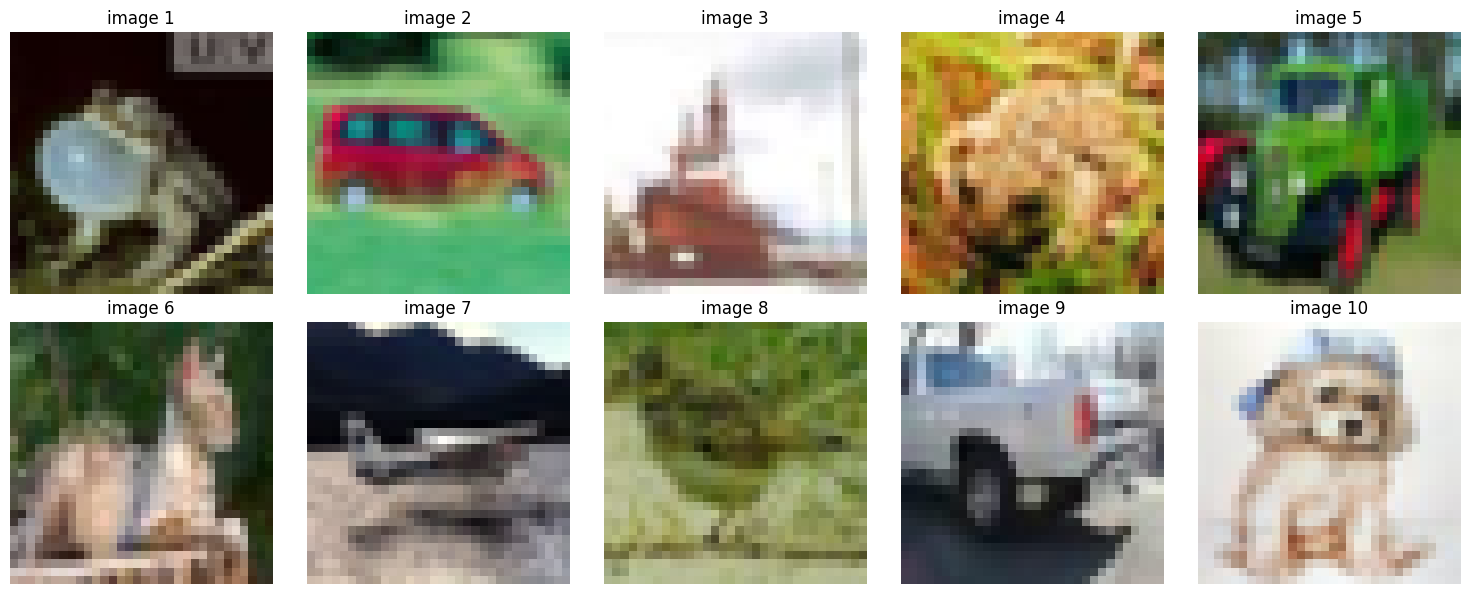

In [ ]:
# Find some information about data
import numpy as np
import matplotlib.pyplot as plt
file_name = "cifar_test_nolabel.pkl"

data = unpickle(file_name)
print(type(data))
print(data.keys())    # it has 2 keys: b'data', b'ids'
print(data[b'ids'])   # it has 10000 images
array_data = np.array(data[b'data'])
print(array_data.shape) # # each image is (32,32,3), the total is (10000, 32, 32, 3)
array_data = array_data.reshape((10000, 32, 32, 3))

# First Image
first_index = data[b'ids'][0]
plt.imshow(array_data[0])
plt.title("first")
plt.axis('off')
plt.show()

# First 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(array_data[i])
    ax.axis('off')
    label_index = i
    ax.set_title(f"image {i+1}")
plt.tight_layout()
plt.show()


In [ ]:
# To deal with imags in test dataset

transformed_data = []
for img_array in array_data:
    transformed_img = transform(img_array)
    transformed_img = transformed_img.to('cuda')
    transformed_data.append(transformed_img)

batch_tensor = torch.stack(transformed_data)  # (N, C, H, W)
print(batch_tensor.shape)


model.eval()
with torch.no_grad():
    predict_label_orgin = model(batch_tensor)
    predict_label_value, index = torch.max(predict_label_orgin, dim=1) # get max value and its index



torch.Size([10000, 3, 32, 32])


torch.Size([10000])
2
bird


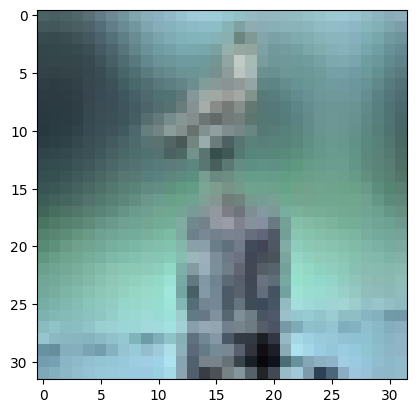

In [ ]:
# Show some information
print(index.shape)
plt.imshow(array_data[10])
print(index[10].item())
print(classes[index[10]])
# print(classes[4])

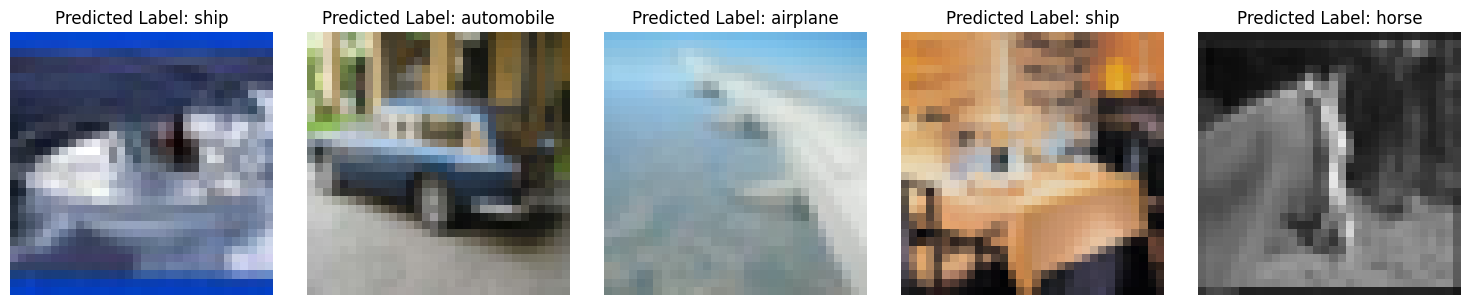

In [ ]:
# show some related results
import random
predicted_labels = index.cpu().numpy()

# random select
num_images = len(index)
selected_indices = random.sample(range(num_images), 5)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
# draw the pictures
for i in range(len(selected_indices)):
    idx = selected_indices[i]
    ax = axes[i]


    pred_label = classes[predicted_labels[idx]]

    ax.imshow(array_data[idx])
    ax.set_title(f'Predicted Label: {pred_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

ids = list(range(len(index)))  # get id for index

labels_csv = [idx.item() for idx in index] # get labels

#  DataFrame
df = pd.DataFrame({'ID': ids, 'Labels': labels_csv})


In [ ]:
label_counts = df['Labels'].value_counts()

print(label_counts)


Labels
3    1119
9    1081
5    1066
8    1015
7    1010
1     991
2     969
4     939
6     914
0     896
Name: count, dtype: int64


In [ ]:
df.to_csv("output.csv", index=False)
print("csv finished")

csv finished
